# Bank Marketing Predictions

Dataset retrieved from [Kaggle](https://www.kaggle.com/henriqueyamahata/bank-marketing)

This dataset is filled with outcomes of marketing campaign phone calls from a Portuguese banking institution. Each phone call has a target to get the customer to subscribe to a bank term deposit. This is what we will be training the model to predict.

The large issue with this dataset is that there is a lot of categorical features that need to be encoded.

In [27]:
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# Model Helpers
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

## Data Analysis

The data is well prepared with no null values. The biggest thing that needs to be tackled is encoding of categorical features.

In [28]:
data = pd.read_csv('bank-marketing.csv')
pd.options.display.max_columns = None
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [29]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Let's look at the age distribution of the callers. Visualization code retrieved from [here](https://www.kaggle.com/henriqueyamahata/bank-marketing-classification-roc-f1-recall).

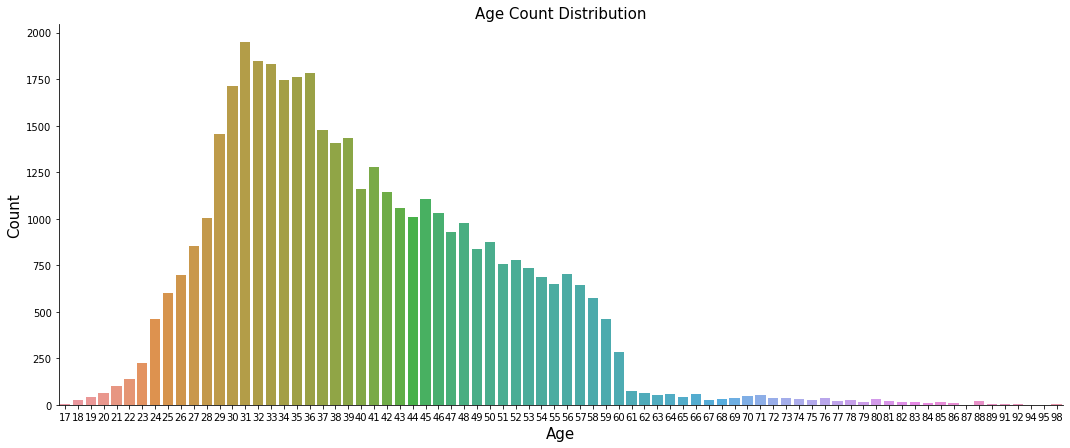

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
sns.countplot(x = 'age', data = data)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Age Count Distribution', fontsize=15)
sns.despine()

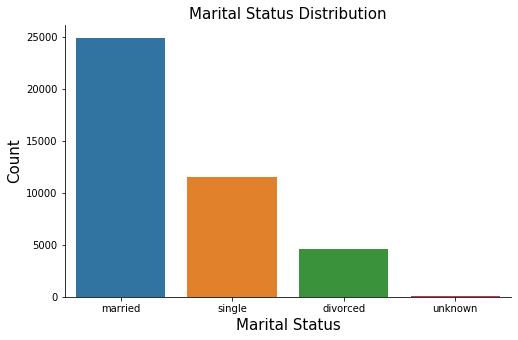

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.countplot(x = 'marital', data = data)
ax.set_xlabel('Marital Status', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Marital Status Distribution', fontsize=15)
sns.despine()

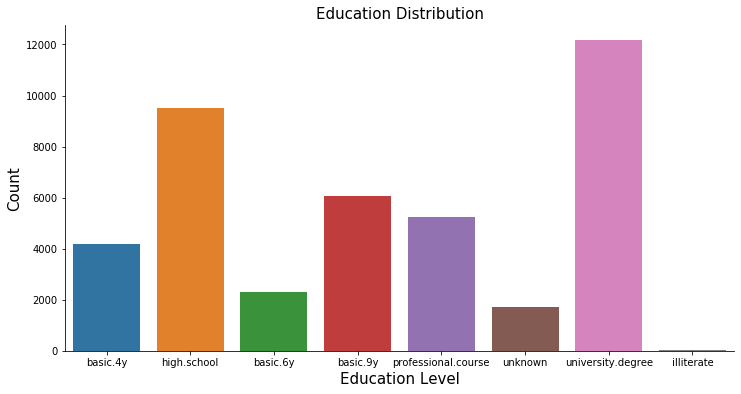

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.countplot(x = 'education', data = data)
ax.set_xlabel('Education Level', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Education Distribution', fontsize=15)
sns.despine()

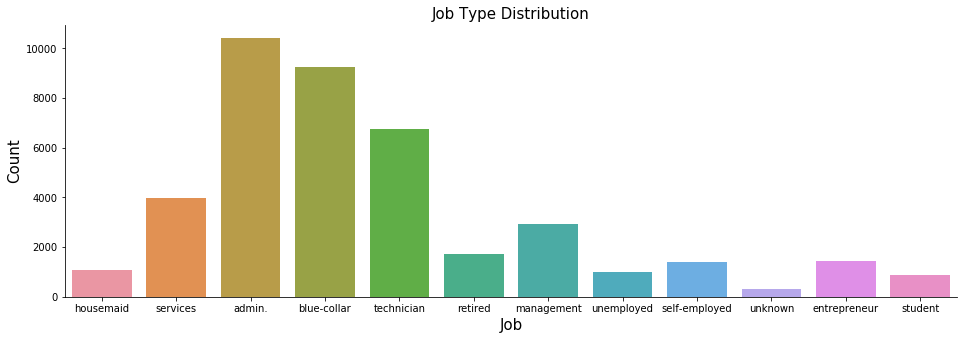

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.countplot(x = 'job', data = data)
ax.set_xlabel('Job', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Job Type Distribution', fontsize=15)
sns.despine()

Calculate the cross validation score on the training data prior to testing on unseen data.

#### Distribution of Subscribed and Non Subscribed Customers

As you can visually see, the dataset is very skewed. If the data is run through a model without being stratified, it will cause us to get improper accuracy results, as about 90% of client phone calls in the dataset did not subscribe.

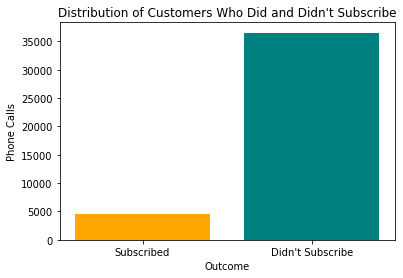

In [34]:
y_class = ['Subscribed', 'Didn\'t Subscribe']

plt.bar(y_class, [np.sum(data['y'] == 'yes'), np.sum(data['y'] == 'no')], color=['orange', 'teal'])
plt.xlabel("Outcome")
plt.ylabel("Phone Calls")
plt.title("Distribution of Customers Who Did and Didn't Subscribe")
plt.show()

#### Distribution of Subscribed Customers on Each Day of The Week

There is slight disparity between how many calls took place on each day of the week by about 1,000 calls. To create a more equal graph, we'll equalize the value counts of each day.

In [35]:
data['day_of_week'].value_counts()

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

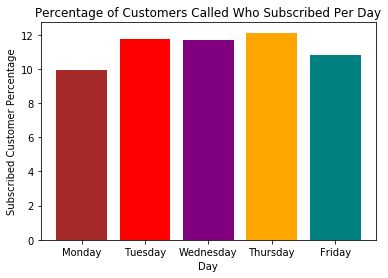

In [36]:
y_class = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.bar(y_class, [(np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'mon')) 
                   / np.sum(data['day_of_week'] == 'mon')) * 100, 
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'tue')) 
                   / np.sum(data['day_of_week'] == 'tue')) * 100,
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'wed')) 
                   / np.sum(data['day_of_week'] == 'wed')) * 100,
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'thu')) 
                   / np.sum(data['day_of_week'] == 'thu')) * 100,
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'fri')) 
                   / np.sum(data['day_of_week'] == 'fri')) * 100],
                color=['brown', 'red', 'purple', 'orange', 'teal'])
plt.xlabel("Day")
plt.ylabel("Subscribed Customer Percentage")
plt.title("Percentage of Customers Called Who Subscribed Per Day")
plt.show()

One of the main takeaways I noticed from the above chart is people are much less likely to subscribe to bank term deposits on Monday.

## Data Engineering

First, I will drop the number of emplyees feature and bin certain categorical features to try and simplify the dataset.

In [37]:
data.pop('nr.employed')

bin_education = {
    "university.degree": "university.degree",
    "professional.course": "professional.course",
    "high.school": "high.school",
    "basic.9y": "basic",
    "basic.6y": "basic",
    "basic.4y": "basic",
    "unknown": "unknown",
    "illiterate": "unknown"
}
data.education = data.education.map(bin_education)

Now, I am applying a form of one hot encoding to categorical features

In [38]:
data = pd.get_dummies(data, columns=['job'], prefix = ['job'])
data = pd.get_dummies(data, columns=['marital'], prefix = ['marital'])
data = pd.get_dummies(data, columns=['education'], prefix = ['education'])
data = pd.get_dummies(data, columns=['default'], prefix = ['default'])
data = pd.get_dummies(data, columns=['housing'], prefix = ['housing'])
data = pd.get_dummies(data, columns=['loan'], prefix = ['loan'])
data = pd.get_dummies(data, columns=['contact'], prefix = ['contact'])
data = pd.get_dummies(data, columns=['month'], prefix = ['month'])
data = pd.get_dummies(data, columns=['day_of_week'], prefix = ['day_of_week'])
data = pd.get_dummies(data, columns=['poutcome'], prefix = ['poutcome'])

The number of days since last call feature has a value of 999 if the customer hasn't been called before. This can possibly create unwanted bias. Instead of setting a wild number that has an unknown purpose, 999 should be set to 0 and a new featured named 'called_before' should be created that will be a boolean value.

In [39]:
data['called_before'] = data.pdays.apply(lambda row: 0 if (row == 999) else 1)
data['pdays'] = data.pdays.apply(lambda row: 0 if (row == 999) else row)

The target column is currently either 'yes' or 'no' strings. That can't be fed into the model, so it should be encoded to 1 or 0.

In [40]:
data['y'] = data.y.apply(lambda row: 1 if (row == 'yes') else 0)

## Create Training and Test Sets

There are a total of 4,640 samples out of 41,188 samples where clients have subscribed to bank term deposits. To properly train the model, the training set should be stratified in half. This means that half the samples are non subscribers and half are subscribers. That allows for the model to properly learn from the dataset and allow us to see true performance metrics. For our training set, I will do 4,000 non subscribers and 4,000 subscribers (8,000 total). That leaves us 620 non subscribers and 620 subscribers (1,240 total) stratified samples to test the trained model with. 

Divide up the data based on its predetermined label and assign to variables for easy management and also randomize each labeled variable to give the model a variety of inputs.

In [41]:
X_not_sub, X_sub = data[data.y == 0].sample(frac=1), data[data.y == 1].sample(frac=1)
y_not_sub, y_sub = X_not_sub.pop('y'), X_sub.pop('y')

#### Sets for Random Forest

Create the stratified training and test sets.

In [42]:
X_train, y_train = X_not_sub[:4000].append(X_sub[:4000]), y_not_sub[:4000].append(y_sub[:4000])
X_test, y_test = X_not_sub[4000:4620].append(X_sub[4000:4620]), y_not_sub[4000:4620].append(y_sub[4000:4620])

#### Sets for Stochastic Gradient Descent

SGD requires data to be scaled in order for learning to converge well, so below we are scaling the data.

In [43]:
sc = StandardScaler() #center the distribution around zero (mean), with a standard deviation of 1.
sc.fit(X_train)
X_std = sc.transform(X_train.append(X_test))

Using Principal Component Analysis on scaled data to Stochastic Gradient Descent.

In [44]:
X_pca = PCA(0.90, svd_solver='full').fit_transform(X_std)

X_pca.shape

(9240, 36)

Split up the PCA data into training and test sets

In [45]:
X_train_pca = X_pca[:8000]
X_test_pca = X_pca[8000:9240]

## Train the Model

### Random Forest Model

First, we will be using the Random Forest model accompanies with GridSearchCV to help find the optimal hyper-parameters when fitting the model. We then will test the model's performance using accuracy, precision, recall, the AUC derived from the ROC curve, and the sum of samples that were misclassified.

#### Training the model

In [46]:
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=100)

Setup the GridSearchCV parameters and fit the model on them.

In [47]:
rnd_params = [
   { 
     'max_depth': [None, 2, 4, 6, 8, 10, 12], 
     'min_samples_leaf' : [1, 2, 3, 4, 5],
     'max_leaf_nodes': [None, 4, 8, 12, 14],
   },
]

rnd_cv = GridSearchCV(estimator=rnd_clf, param_grid=rnd_params, cv=4)
rnd_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'ma

In [48]:
print('Optimal params: {}'.format(rnd_cv.best_estimator_))

Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Calculate the cross validation score on the training data prior to testing on unseen data.

In [49]:
cross_val_score(rnd_cv, X_train, y_train, cv=3, scoring="accuracy")

array([0.88830585, 0.87471868, 0.88447112])

#### Testing on unseen data

In [50]:
y_pred = rnd_cv.predict(X_test)

print("Accuracy score: ", (accuracy_score(y_test, y_pred)))
print("Precision score: ", (precision_score(y_test, y_pred)))
print("Recall score: ", (recall_score(y_test, y_pred)))

Accuracy score:  0.882258064516129
Precision score:  0.8376068376068376
Recall score:  0.9483870967741935


In [51]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under the curve: {}'.format(roc_auc))

Area under the curve: 0.8822580645161291


In [52]:
print('Misclassified samples: ' + str((y_test != y_pred).sum()))

Misclassified samples: 146


### Stochastic Gradient Decsent Model with Log or Hinge Loss

Next, we will try the Stochastic Gradient Descent model using GridSearchCV to automate hyper-parameter selection which includes selecting either log or hinge loss depending on which performs better. We then will test the model's performance using accuracy, precision, recall, the AUC derived from the ROC curve, and the sum of samples that were misclassified.

#### Training the model

In [42]:
sgd_clf = SGDClassifier(tol=1e-3, random_state=42, loss='log')

Setup the GridSearchCV parameters and fit the model on them.

In [ ]:
sgd_params = [
   { 
        'max_iter': [1000, 1500, 2000],
        'loss': ['log', 'hinge'],
        'learning_rate': ['constant', 'optimal', 'adaptive'],
        'eta0': [0.3, 0.5, 0.8],
        'penalty': ['l2', 'l1']
   },
]

sgd_cv = GridSearchCV(estimator=sgd_clf, param_grid=sgd_params, cv=4)
sgd_cv.fit(X_train_pca, y_train)

In [ ]:
print('Optimal params: {}'.format(sgd_cv.best_estimator_))

Calculate the cross validation score on the training data prior to testing on unseen data.

In [ ]:
cross_val_score(rnd_cv, X_train_pca, y_train, cv=3, scoring="accuracy")

#### Testing on unseen data

In [ ]:
y_pred_pca = sgd_cv.predict(X_test_pca)

print("Accuracy score: ", (accuracy_score(y_test, y_pred_pca)))
print("Precision score: ", (precision_score(y_test, y_pred_pca)))
print("Recall score: ", (recall_score(y_test, y_pred_pca)))

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_pca)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under the curve: {}'.format(roc_auc))